In [1]:
import os
import sys
import gains as genetic
from gains.salt_generator import *
import pandas as pd
import rdkit
import pickle
from math import exp
import numpy as np
import random
import unittest
import datetime
import sys
import sklearn
import salty
from sklearn.linear_model import LinearRegression as lin

from numpy import array, all
from rdkit.Chem import Draw
from rdkit import RDConfig
from rdkit.Chem import FragmentCatalog
from rdkit import RDConfig
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import ShowMol
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.ML.Descriptors.MoleculeDescriptors import\
    MolecularDescriptorCalculator as calculator

%matplotlib inline

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]   

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)  

In [6]:
from __future__ import absolute_import, division, print_function
import gains as genetic
from rdkit.Chem import AllChem as Chem
from rdkit.ML.Descriptors.MoleculeDescriptors import\
    MolecularDescriptorCalculator as calculator
from rdkit.Chem.rdmolfiles import MolToPDBFile
import numpy as np
from numpy import array
import pandas as pd
import datetime
import salty
from math import exp
import random


def guess_password(target, anion, parent_candidates, model_ID):
    startTime = datetime.datetime.now()

    def fnGetFitness(genes):
        return get_fitness(anion, genes, target, model_ID)

    def fnDisplay(candidate, mutation):
        display(candidate, mutation, startTime)

    def fnShowIon(genes, target, mutation_attempts, sim_score,
                  molecular_relative):
        show_ion(genes, target, mutation_attempts, sim_score,
                 molecular_relative, model_ID, anion)

    optimalFitness = 0.99
    geneSet = genetic.generate_geneset()
    best = genetic.get_best(fnGetFitness,
                            optimalFitness, geneSet, fnDisplay,
                            fnShowIon, target, parent_candidates)
    return best


def display(candidate, mutation, startTime):
    timeDiff = datetime.datetime.now() - startTime
    print("{}\t{}\t{}".format(
        candidate.Genes, candidate.Fitness, mutation, timeDiff))


def get_fitness(anion, genes, target, model_ID):
    cation = Chem.MolFromSmiles(genes)
    model = genetic.load_data("{}.sav".format(model_ID), pickleFile=True)
    deslist = genetic.load_data("{}_descriptors.csv".format(model_ID))
    feature_vector = []

    for item in deslist:

        if "anion" in item:
            with genetic.suppress_stdout_stderr():
                feature_vector.append(calculator([item.partition('-')
                                      [0]]).CalcDescriptors(anion)[0])
        elif "cation" in item:
            with genetic.suppress_stdout_stderr():
                feature_vector.append(calculator([item.partition('-')
                                      [0]]).CalcDescriptors(cation)[0])
        elif "Temperature, K" in item:
            feature_vector.append(298.15)
        elif "Pressure, kPa" in item:
            feature_vector.append(101.325)
        else:
            print("unknown descriptor in list: %s" % item)
    features_normalized = (feature_vector - deslist.iloc[0].values) /\
        deslist.iloc[1].values
    prediction = np.round(np.exp(model.predict(np.array(features_normalized).
                          reshape(1, -1))[0]), decimals=2)
    error = abs((prediction - target) / target)
    error = np.average(error)
    return 1 - error, prediction


def show_ion(genes, target, mutation_attempts, sim_score, molecular_relative,
             model_ID, anion):
    mol = Chem.MolFromSmiles(genes)
    fitness, mol_property = get_fitness(anion, genes, target, model_ID)
    print("{}\t{}".format("number of atoms: ", mol.GetNumAtoms()))
    print("{}\t{}".format("mutation attempts: ", mutation_attempts))
    print("with final evaluation: \t\t{} (kg/m)".format(mol_property))
    print("similarity score:  {0:10.3f}".format(sim_score))
    print("{}\t{}\n".format("molecular relative: ",
          salty.check_name(molecular_relative)))


def generate_solvent(target, model_ID, heavy_atom_limit=30,
                     sim_bounds=[0.6, 1.0], hits=1, write_file=False):

    parent_candidates = eval(genetic.load_data("{}_summary.csv".
                             format(model_ID)).loc[1][1])
    anion_candidates = eval(genetic.load_data("{}_summary.csv".
                            format(model_ID)).loc[2][1])
    cols = ["Salt ID", "Salt Smiles", "Cation Heavy Atoms",
            "Tanimoto Similarity Score", "Molecular Relative", "Anion",
            "Model Density", "MD Density", "Error"]
    salts = pd.DataFrame(columns=cols)
    for i in range(1, hits + 1):
        while True:
            anion_smiles = random.sample(list(anion_candidates), 1)[0]
            anion = Chem.MolFromSmiles(anion_smiles)
            best = guess_password(target, anion, parent_candidates, model_ID)
            tan_sim_score, sim_index =\
                genetic.molecular_similarity(best, parent_candidates)
            cation_heavy_atoms = best.Mol.GetNumAtoms()
            salt_smiles = best.Genes + "." + Chem.MolToSmiles(anion)
            if cation_heavy_atoms < heavy_atom_limit and\
                    tan_sim_score >= sim_bounds[0] and\
                    tan_sim_score < sim_bounds[1] and\
                    salt_smiles not in salts["Salt Smiles"]:
                scr, pre = get_fitness(anion, best.Genes, target, model_ID)
                if i < 10:
                    CAT_ID = "C0%s" % i
                    AN_ID = "A0%s" % i
                else:
                    CAT_ID = "C%s" % i
                    AN_ID = "A%s" % i
                salt_ID = CAT_ID + "_" + AN_ID
                molecular_relative = salty.check_name(parent_candidates
                                                      [sim_index])
                anion_name = salty.check_name(anion_smiles)
                new_entry = pd.DataFrame([[salt_ID, salt_smiles,
                                           cation_heavy_atoms,
                                           tan_sim_score,
                                           molecular_relative,
                                           anion_name, pre]],
                                         columns=cols[:-2])
                try:
                    cation = Chem.AddHs(best.Mol)
                    Chem.EmbedMolecule(cation, Chem.ETKDG())
                    Chem.UFFOptimizeMolecule(cation)
                    anion = Chem.AddHs(anion)
                    Chem.EmbedMolecule(anion, Chem.ETKDG())
                    Chem.UFFOptimizeMolecule(anion)
                    new = pd.DataFrame(pd.concat([salts, new_entry]),
                                       columns=cols)
                except BaseException:
                    continue
                if write_file:
                    MolToPDBFile(cation,
                                 "{}.pdb".format(CAT_ID))
                    MolToPDBFile(anion,
                                 "{}.pdb".format(AN_ID))
                break
            else:
                continue
        if write_file:
            pd.DataFrame.to_csv(new, path_or_buf="salt_log.csv", index=False)
        salts = new
    if not write_file:
        return new


In [2]:
from gains.salt_generator import generate_solvent

In [11]:
generate_solvent(target=[1000], model_ID="density_m3", heavy_atom_limit=60, sim_bounds=[0.4, 1], hits=1)

/Users/wesleybeckner/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator MLPRegressor from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


CCCCCCCC[n+]1cccc(c1)C#N	0.9131400000000001	starting structure
CCCCCCCC[n+]1cc(N)cc(C#N)c1	0.9276800000000001	add_rdkit_fragment
CCCCCCCC[n+]1cc(C#N)cc(NC(=O)O)c1	0.9891599999999999	add_rdkit_fragment
CCCCCCCC[n+]1cc(C#N)c(C(N)=O)c(NC(=O)O)c1	0.9917	add_rdkit_fragment
number of atoms: 	23
mutation attempts: 	14
with final evaluation: 		991.7 (kg/m)
similarity score:       0.518
molecular relative: 	1-butyl-3-methylimidazolium



,Salt ID,Salt Smiles,Cation Heavy Atoms,Tanimoto Similarity Score,Molecular Relative,Anion,Model Density,MD Density,Error
0,C01_A01,CCCCCCCC[n+]1cc(C#N)c(C(N)=O)c(NC(=O)O)c1.CCCC...,23,0.517647,1-butyl-3-methylimidazolium,"1,4-bis((2-ethylhexyl)oxy)-1,4-dioxobutane-2-s...",991.7,NaN,NaN


In [4]:
model_ID = "cpt_density_m1"


In [66]:
target = np.array([500,600])
prediction = np.round(np.exp(model.predict(np.array(features_normalized).reshape(1, -1))[0]), decimals=2)

error = abs((prediction - target) / target)
error

array([ 0.2548    ,  0.86896667])

In [42]:
np.array([5,6]) - np.array([6,6])

array([-1,  0])

In [84]:
target = np.array([1000])
model_ID = "density_m3"
genes = "CCCCN"
anion = Chem.MolFromSmiles("Cl")
    
cation = Chem.MolFromSmiles(genes)
model = genetic.load_data("{}.sav".format(model_ID), pickleFile=True)
deslist = genetic.load_data("{}_descriptors.csv".format(model_ID))
feature_vector = []

for item in deslist:
    if "anion" in item:
        with genetic.suppress_stdout_stderr():
            feature_vector.append(calculator([item.partition('-')
                                  [0]]).CalcDescriptors(anion)[0])
    elif "cation" in item:
        with genetic.suppress_stdout_stderr():
            feature_vector.append(calculator([item.partition('-')
                                  [0]]).CalcDescriptors(cation)[0])
    elif "Temperature, K" in item:
        feature_vector.append(298.15)
    elif "Pressure, kPa" in item:
        feature_vector.append(101.325)
    else:
        print("unknown descriptor in list: %s" % item)
features_normalized = (feature_vector - deslist.iloc[0].values) /\
    deslist.iloc[1].values
prediction = np.round(np.exp(model.predict(np.array(features_normalized).
                      reshape(1, -1))[0]), decimals=2)
error = abs((prediction - target) / target)
error = np.average(error)
print(error, prediction, target)

0.06061 1060.61 [1000]


/Users/wesleybeckner/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator MLPRegressor from version 0.19.1 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [7]:
target = 1000
model_ID = "cpt_density_m1"
generate_solvent(target, model_ID, sim_bounds=[0.1, 1], heavy_atom_limit=1e8, hits=1)

TypeError: only length-1 arrays can be converted to Python scalars

In [6]:
salty.check_name("phosphate")

'[O-]P(=O)([O-])[O-]'

In [11]:
out = pd.DataFrame()
for j in np.arange(40,100,10):
    df = pd.read_csv("../../designer_molecules/pdb_files/model_3/1500kgm3/%s/salt_log.csv" % j) #or salt_candidates
    inner = pd.DataFrame()
    for i in range(1,26):
        if i < 10:
            CAT_ID = "C0%s" % i
            AN_ID = "A0%s" % i
        else:
            CAT_ID = "C%s" % i
            AN_ID = "A%s" % i
        Salt_ID = CAT_ID + "_" + AN_ID
        try:
            mean = np.round(pd.read_csv("../../designer_molecules/pdb_files/model_3/1500kgm3/%s/%s.dens" % (j, Salt_ID)).describe().loc["mean"][1])
            std = np.round(pd.read_csv("../../designer_molecules/pdb_files/model_3/1500kgm3/%s/%s.dens" % (j, Salt_ID)).describe().loc["std"][1])
            value = ("{}{}{}".format(mean," +/- ", std))
            true = df.loc[df["Salt ID"] == Salt_ID, "Model Density"]
            difference = (true - mean)/true*100
            df.loc[df["Salt ID"] == Salt_ID, "MD Density"] = value
            df.loc[df["Salt ID"] == Salt_ID, "Error"] = difference #this is % Difference in old version
        except:
            pass
    df.dropna(inplace=True)
    out = pd.concat([df, out], axis=0) 
out.reset_index(drop=True, inplace=True)
out

,Salt ID,Salt Smiles,Cation Heavy Atoms,Tanimoto Similarity Score,Molecular Relative,Anion,Model Density,MD Density,Error
0,C03_A03,O=C(C[n+]1ccccc1)OCCO.O=S(=O)(F)[N-]S(=O)(=O)F,13,0.917647,1-(2-ethoxy-2-oxoethyl)-pyridinium,bis(fluorosulfonyl)amide,1514.04,1511.0 +/- 33.0,0.200787
1,C05_A05,COCCn1cc[n+](C)c1C.O=S(=O)([O-])C(F)(F)C(F)OC(...,11,0.915493,"1-(2-hydroxyethyl)-2,3-dimethylimidazolium","1,1,2-trifluoro-2-(perfluoroethoxy)ethanesulfo...",1502.11,1423.0 +/- 28.0,5.266592
2,C06_A06,C[n+]1ccn(CCCS(=O)(=O)OO)c1.O=S(=O)([N-]S(=O)(...,14,0.924528,1-methyl-3-(3-sulfopropyl)-imidazolium,bis[(trifluoromethyl)sulfonyl]imide,1498.09,1593.0 +/- 37.0,-6.335400
3,C09_A09,CCC[N+](C)(C)CCC.O=S(=O)([N-]S(=O)(=O)C(F)(F)C...,9,0.903226,"N-ethyl-N,N-dimethyl-1-propanaminium",bis(perfluoroethylsulfonyl)imide,1491.02,1453.0 +/- 51.0,2.549932
4,C11_A11,CC(S)CCCC[n+]1ccn(CCC#N)c1.O=S(=O)([O-])C(F)(F...,16,0.925373,3-(2-cyanoethyl)-1-hexyl-1H-imidazolium,"1,1,2-trifluoro-2-(perfluoroethoxy)ethanesulfo...",1496.91,1364.0 +/- 46.0,8.878957
5,C13_A13,Cn1cc[n+](CCCCCCOS)c1.O=S(=O)([O-])C(F)(F)C(F)...,14,0.930851,3-(6-hydroxyhexyl)-1-methylimidazolium,"1,1,2,3,3,3-hexafluoro-1-propanesulfonate",1500.32,1367.0 +/- 39.0,8.886104
6,C14_A14,N#CCCn1cc[n+](CC=CO)c1.O=S(=O)([N-]S(=O)(=O)C(...,13,0.932367,3-allyl-1-(2-cyanoethyl)-1H-imidazolium,bis(trifluoromethylsulfonyl)imide,1513.98,1512.0 +/- 33.0,0.130781
7,C15_A15,CC[n+]1ccn(CC(C)C)c1.O=S(=O)([N-]S(=O)(=O)C(F)...,11,0.963235,1-isobutyl-3-methylimidazolium,bis(perfluoroethylsulfonyl)imide,1488.39,1446.0 +/- 56.0,2.848044
8,C19_A19,CCSCCCn1c(C)cc(C)[n+]1-c1ccccc1.O=S(=O)([N-]S(...,19,0.913924,"1-phenyl-2-butyl-3,5-dimethylpyrazolium",bis(perfluoroethylsulfonyl)imide,1485.03,1376.0 +/- 32.0,7.341939
9,C22_A22,C[N+]1(C)CCOCC1.O=S(=O)([N-]S(=O)(=O)C(F)(F)F)...,8,0.916667,4-ethyl-4-methylmorpholin-4-ium,bis[(trifluoromethyl)sulfonyl]imide,1507.34,1608.0 +/- 47.0,-6.677989


In [190]:
out_1000.reset_index(inplace=True, drop=True)
out_1000

,level_0,index,Salt ID,Salt Smiles,Cation Heavy Atoms,Tanimoto Similarity Score,Molecular Relative,Anion,Model Density,MD Density,% Difference
0,0,0,C01_A01,CCCCCCCC[n+]1cc[nH]c1.COP(=O)([O-])OC,13,0.900000,1-butylimidazolium,dimethylphosphate,978,1069.0 +/- 38.0,-35.2634
1,1,1,C04_A04,Cn1cc[n+](CCCCCCCCCCP)c1.N#C[S-],17,0.937853,1-methyl-3-octyl-1H-imidazolium,thiocyanate,999,1013.0 +/- 25.0,-29.7449
2,2,2,C05_A05,CCCC(CC)CCCCn1cc[n+](CCC#N)c1.N#C[S-],19,0.940299,3-(2-cyanoethyl)-1-decyl-1H-imidazolium,thiocyanate,1024,992.0 +/- 39.0,-35.6648
3,3,3,C07_A07,Cn1cc[n+](CCCCCCCCO)c1.CCC(=O)[O-],15,0.972067,3-(6-hydroxyhexyl)-1-methylimidazolium,propionate,1017,1008.0 +/- 31.0,-30.0014
4,4,4,C08_A08,CCCCn1c(C)cc(C)[n+]1-c1cccc(F)c1.NCCCCC(N)C(=O...,18,0.905455,"1-phenyl-2-butyl-3,5-dimethylpyrazolium",L-lysinate,1036,1059.0 +/- 36.0,-24.0198
5,5,5,C09_A09,CCCCCCC(C)CC[n+]1cccc(C#N)c1.N#C[N-]C#N,18,0.929515,3-cyano-1-octylpyridinium,dicyanamide,1013,986.0 +/- 34.0,-25.8508
6,6,6,C11_A11,CCc1c(C)cc(C)c[n+]1CCCC(C)CC.CCO[PH](=O)[O-],17,0.975664,"1-hexyl-3,5-dimethylpyridinium",ethyl phosphonate,1029,996.0 +/- 32.0,-31.9332
7,7,7,C12_A12,CCCC[P+](C)(CCCC)CCC(C)N.CCC(=O)[O-],15,0.928571,(3-aminopropyl)tributylphosphonium,propionate,982,913.0 +/- 25.0,-32.0263
8,8,8,C13_A13,CCCCCCC[N+]1(C)CCOCC1.CC(C)CC(N)C(=O)[O-],14,0.990909,4-methyl-4-octylmorpholin-4-ium,L-leucinate,1028,989.0 +/- 37.0,-25.2384
9,9,9,C16_A16,CCC[n+]1ccn(CC(C)C)c1.CC(C)CC(N)C(=O)[O-],12,0.963235,1-isobutyl-3-methylimidazolium,L-leucinate,1023,965.0 +/- 27.0,-36.3539


In [192]:
out_1000

,level_0,index,Salt ID,Salt Smiles,Cation Heavy Atoms,Tanimoto Similarity Score,Molecular Relative,Anion,Model Density,MD Density,% Difference
0,0,0,C01_A01,CCCCCCCC[n+]1cc[nH]c1.COP(=O)([O-])OC,13,0.900000,1-butylimidazolium,dimethylphosphate,978,1069.0 +/- 38.0,-35.2634
1,1,1,C04_A04,Cn1cc[n+](CCCCCCCCCCP)c1.N#C[S-],17,0.937853,1-methyl-3-octyl-1H-imidazolium,thiocyanate,999,1013.0 +/- 25.0,-29.7449
2,2,2,C05_A05,CCCC(CC)CCCCn1cc[n+](CCC#N)c1.N#C[S-],19,0.940299,3-(2-cyanoethyl)-1-decyl-1H-imidazolium,thiocyanate,1024,992.0 +/- 39.0,-35.6648
3,3,3,C07_A07,Cn1cc[n+](CCCCCCCCO)c1.CCC(=O)[O-],15,0.972067,3-(6-hydroxyhexyl)-1-methylimidazolium,propionate,1017,1008.0 +/- 31.0,-30.0014
4,4,4,C08_A08,CCCCn1c(C)cc(C)[n+]1-c1cccc(F)c1.NCCCCC(N)C(=O...,18,0.905455,"1-phenyl-2-butyl-3,5-dimethylpyrazolium",L-lysinate,1036,1059.0 +/- 36.0,-24.0198
5,5,5,C09_A09,CCCCCCC(C)CC[n+]1cccc(C#N)c1.N#C[N-]C#N,18,0.929515,3-cyano-1-octylpyridinium,dicyanamide,1013,986.0 +/- 34.0,-25.8508
6,6,6,C11_A11,CCc1c(C)cc(C)c[n+]1CCCC(C)CC.CCO[PH](=O)[O-],17,0.975664,"1-hexyl-3,5-dimethylpyridinium",ethyl phosphonate,1029,996.0 +/- 32.0,-31.9332
7,7,7,C12_A12,CCCC[P+](C)(CCCC)CCC(C)N.CCC(=O)[O-],15,0.928571,(3-aminopropyl)tributylphosphonium,propionate,982,913.0 +/- 25.0,-32.0263
8,8,8,C13_A13,CCCCCCC[N+]1(C)CCOCC1.CC(C)CC(N)C(=O)[O-],14,0.990909,4-methyl-4-octylmorpholin-4-ium,L-leucinate,1028,989.0 +/- 37.0,-25.2384
9,9,9,C16_A16,CCC[n+]1ccn(CC(C)C)c1.CC(C)CC(N)C(=O)[O-],12,0.963235,1-isobutyl-3-methylimidazolium,L-leucinate,1023,965.0 +/- 27.0,-36.3539


In [183]:
backup = out_1000

In [186]:
out_1000 = backup

In [198]:
target = 1000
model_ID = "density_m3"
#out_1000.reset_index(inplace=True)
for i in range(len(out_1000["Salt Smiles"])):
    genes = out_1000["Salt Smiles"][i].split(".")[0]
    anion = Chem.MolFromSmiles(out_1000["Salt Smiles"][i].split(".")[1])
    score, prediction = salt_generator.get_fitness(anion, genes, target, model_ID)
    if score < 0.95:
        print(i)
        out_1000.drop([i], inplace=True)
        out_1000.reset_index(inplace=True, drop=True)
        
    
    #out_1300["Model Density"][i] = prediction
    diff = (float(prediction) - float(out_1000["MD Density"][i].split()[0])) / float(out_1000["MD Density"][i].split()[0]) * 100
    #out_1300["% Difference"][i] = diff
    #print(score)
    #out_1000.reset_index(inplace=True)

20
21
25
35
37


KeyError: 42

In [53]:
out.drop([23,55,58], inplace=True)
out.reset_index(inplace=True)

In [ ]:
driver = webdriver.Chrome()
driver.get("http://www.chemspider.com/")
out.reset_index(inplace=True)
results=[]

In [ ]:
###This cell checks that entries are not existent in the world
from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time

for i in range(52,out.shape[0]):
    ion = out["Salt Smiles"][i].split(".")[0]
    search = driver.find_element_by_xpath("//*[@id=\"ctl00_ctl00_qs_query\"]")
    search.clear()
    search.send_keys(ion)
    submit = driver.find_element_by_xpath("//*[@id=\"ctl00_ctl00_search_btn\"]")
    submit.click()
    time.sleep(5)
    try:
        name = driver.find_element_by_xpath("//*[@id=\"ctl00_ctl00_ContentSection"\
                                            "_ContentPlaceHolder1_RecordViewDetails"\
                                            "_rptDetailsView_ctl00_WrapTitle\"]")
        results.append([ion, name.text])
        print(ion, name.text)
        time.sleep(3)
    except:
        results.append([ion, "new molecule"])
        print("{}\t{}".format("name not found for:",ion))

In [20]:
b = pd.DataFrame(a)
b.to_csv("existance_results.csv",index=False, indicator=True)

NameError: name 'a' is not defined

In [7]:
results
a = np.array(results)
a[:,1]

NameError: name 'results' is not defined

In [224]:
out_1000 = out_1000.loc[out_1000["Tanimoto Similarity Score"] > 0.9]
out_1300 = out_1300.loc[out_1300["Tanimoto Similarity Score"] > 0.9]
out_1500 = out_1500.loc[out_1500["Tanimoto Similarity Score"] > 0.9]

In [228]:
out_1000.reset_index(drop=True, inplace=True)
out_1300.reset_index(drop=True, inplace=True)
out_1500.reset_index(drop=True, inplace=True)

In [229]:
md_1000 = []
std_1000 = []
for i in range(out_1000.shape[0]):
    md_1000.append(out_1000["MD Density"][i].split()[0])
    std_1000.append(out_1000["MD Density"][i].split()[2])
md_1300 = []
std_1300 = []
for i in range(out_1300.shape[0]):
    md_1300.append(out_1300["MD Density"][i].split()[0])
    std_1300.append(out_1300["MD Density"][i].split()[2])
md_1500 = []
std_1500 = []
for i in range(out_1500.shape[0]):
    md_1500.append(out_1500["MD Density"][i].split()[0])
    std_1500.append(out_1500["MD Density"][i].split()[2])

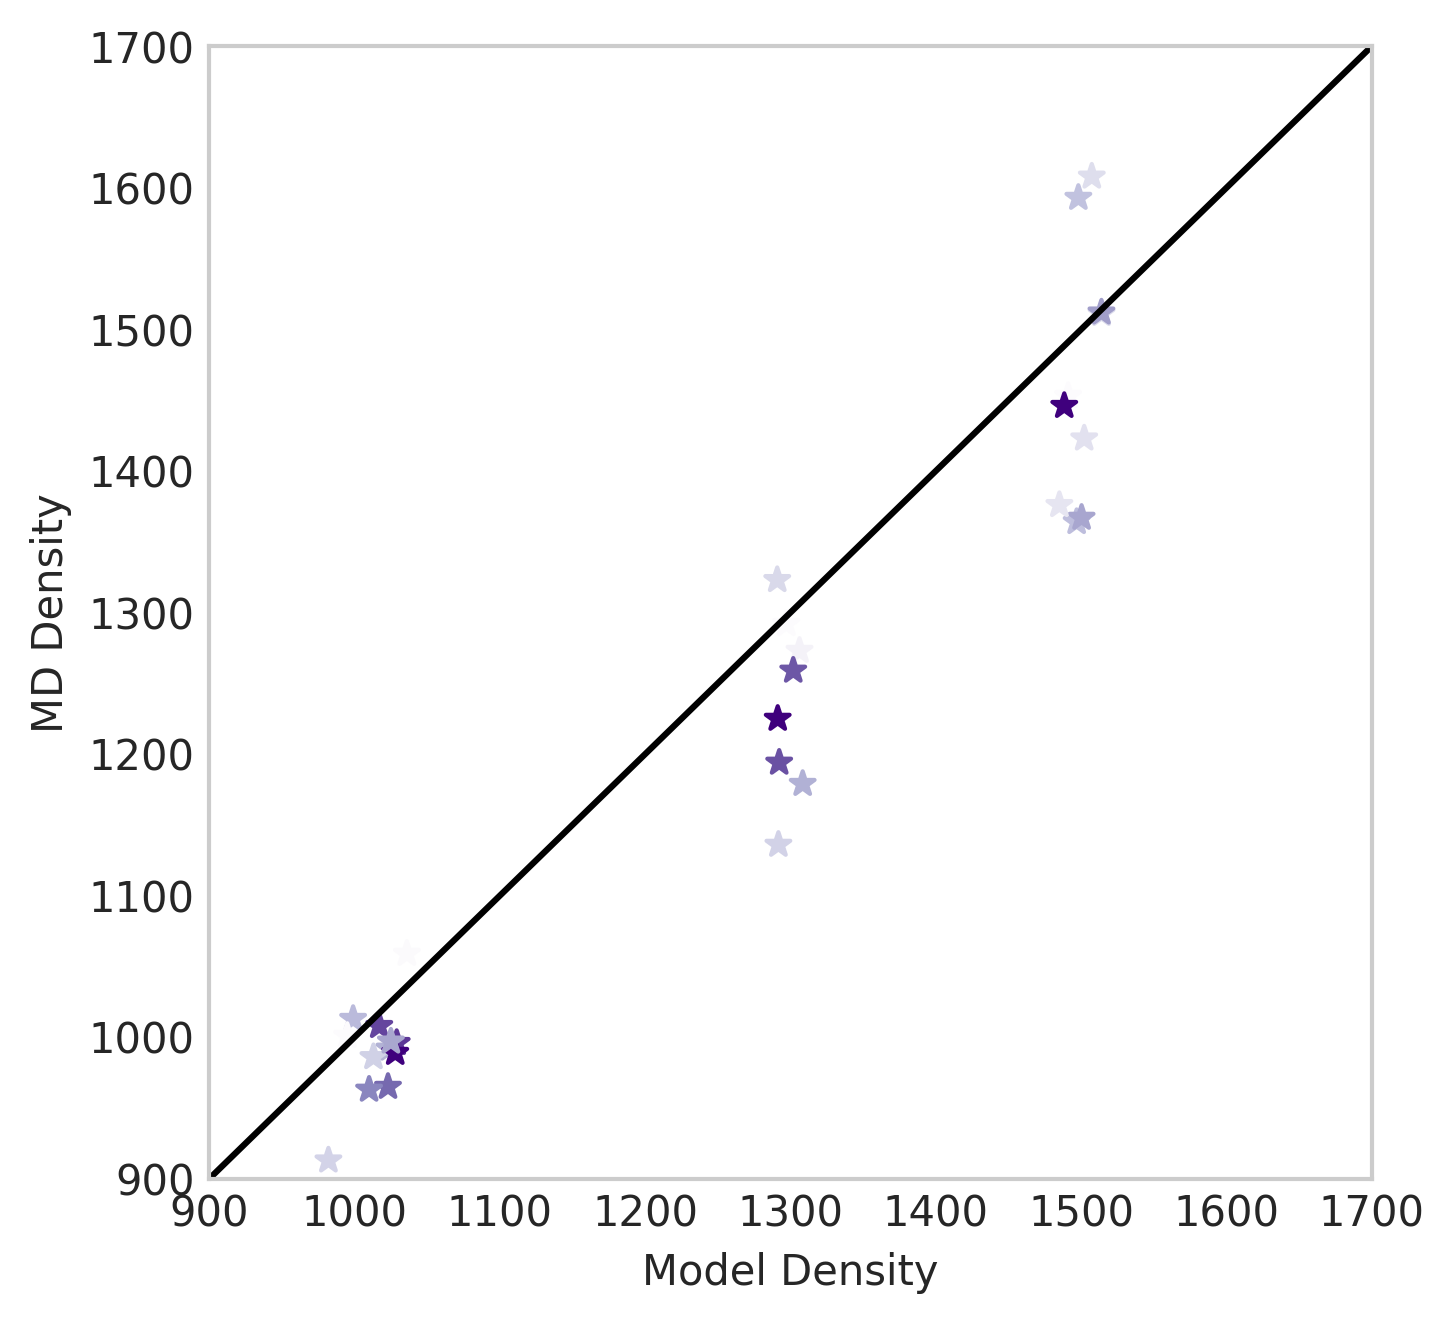

In [234]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as lin
#poop = np.abs(out["% Difference"].values)
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,5), dpi=300)
    ax = fig.add_subplot(111)
    ax.scatter(out_1000["Model Density"], md_1000, marker="*",
               c=out_1000["Tanimoto Similarity Score"], cmap="Purples")
    ax.scatter(out_1300["Model Density"], md_1300, marker="*",
               c=out_1300["Tanimoto Similarity Score"], cmap="Purples")
    ax.scatter(out_1500["Model Density"], md_1500, marker="*",
               c=out_1500["Tanimoto Similarity Score"], cmap="Purples")
    ax.plot([900,1700], [900,1700], linestyle="-", label=None, c="black")
    #ax.plot([0,X0],[Y0,0], label="Best fit R-squared: 0.25")
    #ax.set_xlim(0.4,1)
    #ax.set_ylim(0,11)
    #ax.legend(bbox_to_anchor=(1,1))
    ax.set_ylabel("MD Density")
    ax.set_xlabel("Model Density")
    plt.xlim(900,1700)
    plt.ylim(900,1700)
    ax.grid()
    
fig.savefig(filename='../../designer_molecules/6.eps', 
                       bbox_inches='tight', format='eps') 

In [13]:
df = salty.load_data("cationInfo.csv")
parent_candidates = df["smiles"].unique()
to_plot=[]
for i in range(out.shape[0]):
    smi = out.iloc[i]["Salt Smiles"].split(".")[0]
    mol = Chem.MolFromSmiles(smi)
    chro = genetic.Chromosome(smi, 0)
    score, index = genetic.molecular_similarity(chro, parent_candidates, all=True)
    score.append(out.iloc[i]["Error"])
    to_plot.append(score)
points = np.array(to_plot)
sim_scores = []
for i in range(points.shape[1]-1):
    sim_scores.append(points[:,i])

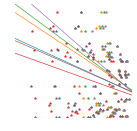

In [19]:
metrics = ["Tanimoto", "Dice", "Cosine", "Sokal", 
           "Kulczynski", "McConnaughey"]
r_sqr = []
import matplotlib.pyplot as plt
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,5), dpi=30)
    ax = fig.add_subplot(111)
    for i in range(len(sim_scores)):
        X=sim_scores[i].reshape(-1,1)
        Y=np.abs(out["Error"]).values.reshape(-1,1)
        model = lin()
        model.fit(X,Y)
        if model.coef_ < 0:
            Y0=model.intercept_
            X0=abs(model.intercept_/model.coef_)
        else:
            print("pos corr")
        r_sqr.append(model.score(X,Y))
        for j in range(len(sim_scores[0])):
        
            if j == 0:
                ax.plot(sim_scores[i][j], np.abs(out.iloc[j]["Error"]), 
                        linestyle="", marker="*", c=tableau20[i*2],
                       label="{:3.4f}, {}".format(r_sqr[i], metrics[i]))
                ax.plot([0,X0],[Y0,0])
    
            else:
                ax.plot(sim_scores[i][j], np.abs(out.iloc[j]["Error"]), 
                        linestyle="", marker="*", c=tableau20[i*2])
    ax.set_xlim(0.2,1)
    ax.set_axis_off()
    ax.set_ylim(0,18)
    ax.set_ylabel("% Error")
    ax.set_xlabel("Similarity Score")
    #ax.legend(bbox_to_anchor=(1.6,1))
    
    ax.grid()
fig.savefig(filename='../../designer_molecules/11.eps', 
                       bbox_inches='tight', format='eps') 